In [99]:
import pandas as pd
import numpy as np
import lightgbm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import optuna
matplotlib.rcParams['font.family']='IPAGothic'

In [37]:
base_path = "../../data/dataframes/"
data = pd.read_pickle(base_path + 'data.pkl')
nomination_onehot = pd.read_pickle(base_path + 'nomination_onehot.pkl')
selected_performers_onehot = pd.read_pickle(base_path + 'selected_performers_onehot.pkl')
selected_directors_onehot = pd.read_pickle(base_path + 'selected_directors_onehot.pkl')
selected_studio_onehot = pd.read_pickle(base_path + 'selected_studio_onehot.pkl')
selected_scriptwriter_onehot = pd.read_pickle(base_path + 'selected_scriptwriter_onehot.pkl')

data.head()

,director,other_nominates,performers,prize,production_studio,screen_time,scriptwriter,title,year,selected_performers,selected_directors,selected_studio,selected_scriptwriter
id,,,,,,,,,,,,,
1,[山田洋次],"[hochi_eigashou, blue_ribbon_award]","[高倉健, 倍賞千恵子, 桃井かおり, 武田鉄矢, 渥美清]",1,[松竹],108,"[山田洋次, 朝間義隆]",幸福の黄色いハンカチ,1978,[高倉健],[山田洋次],[松竹],"[山田洋次, 朝間義隆]"
2,"[浦山桐郎, 橋本幸治]",[],"[田中健, 大竹しのぶ, いしだあゆみ, 高橋悦史, 伊東辰夫, 高瀬春奈, 高山彰, 梅宮...",0,[東宝],161,"[早坂暁, 浦山桐郎]",青春の門 自立篇（1977）,1978,[大竹しのぶ],[],[東宝],[早坂暁]
3,"[新藤兼人, 小松崎和男]",[],"[高橋竹山, 林隆三, 乙羽信子, 金井大, 倍賞美津子, 島村佳江, 観世栄夫, 根岸明美...",0,[独立映画センター],125,[新藤兼人],竹山ひとり旅,1978,[倍賞美津子],[],[],[新藤兼人]
4,"[森谷司郎, 神山征二郎]",[],"[島田正吾, 大滝秀治, 高倉健, 丹波哲郎, 藤岡琢也, 浜田晃, 加藤健一, 江幡連, ...",0,[東宝],169,[橋本忍],八甲田山,1978,"[大滝秀治, 緒形拳, 神山繁, 高倉健, 丹波哲郎]",[神山征二郎],[東宝],[]
5,"[篠田正浩, 永井正夫]",[],"[岩下志麻, 原田芳雄, 奈良岡朋子, 神保共子, 横山リエ, 宮沢亜古, 中村恵子, 殿山...",0,[東宝],117,"[長谷部慶治, 篠田正浩]",はなれ瞽女おりん,1978,"[西田敏行, 樹木希林, 浜村純]",[篠田正浩],[東宝],[]


In [86]:
def plot_feature_importance(feature_imp):
    feature_names = df.drop(["year"], axis="columns").columns
    feature_imp_arg = np.argsort(feature_imp)
    plt.figure(figsize=(20,20))
    plt.barh(range(len(feature_imp_arg)), feature_imp[feature_imp_arg] / len(df), color='b', align='center')
    plt.yticks(range(len(feature_imp_arg)), feature_names[feature_imp_arg])
    plt.show()

# n_features = list(df.drop(["year"], axis=1).columns)
# n_features

In [87]:
def cv_generator(data, df):
    for year in range(1978, 2020):
        train_x = df[df["year"] != year].drop("year", axis=1).values
        test_x = df[df["year"] == year].drop("year", axis=1).values
        train_y = data[data["year"] != year]["prize"].values
        test_y = data[data["year"] == year]["prize"].values
        std_x_train, std_x_test = standarize_(train_x, test_x)
        yield (std_x_train, train_y, std_x_test, test_y)
# gen = cv_generator(data, df)
# next(gen)

In [88]:
def standarize_(x_train, x_test):
    scaler = sklearn.preprocessing.StandardScaler()
    std_x_train = scaler.fit_transform(x_train)
    std_x_test = scaler.transform(x_test)
    return std_x_train, std_x_test

In [89]:
df = pd.concat(
    [
        nomination_onehot, 
        selected_performers_onehot,
        selected_directors_onehot,
        selected_studio_onehot,
        selected_scriptwriter_onehot,
        data["screen_time"],
        data["year"]
    ],
    axis=1
)


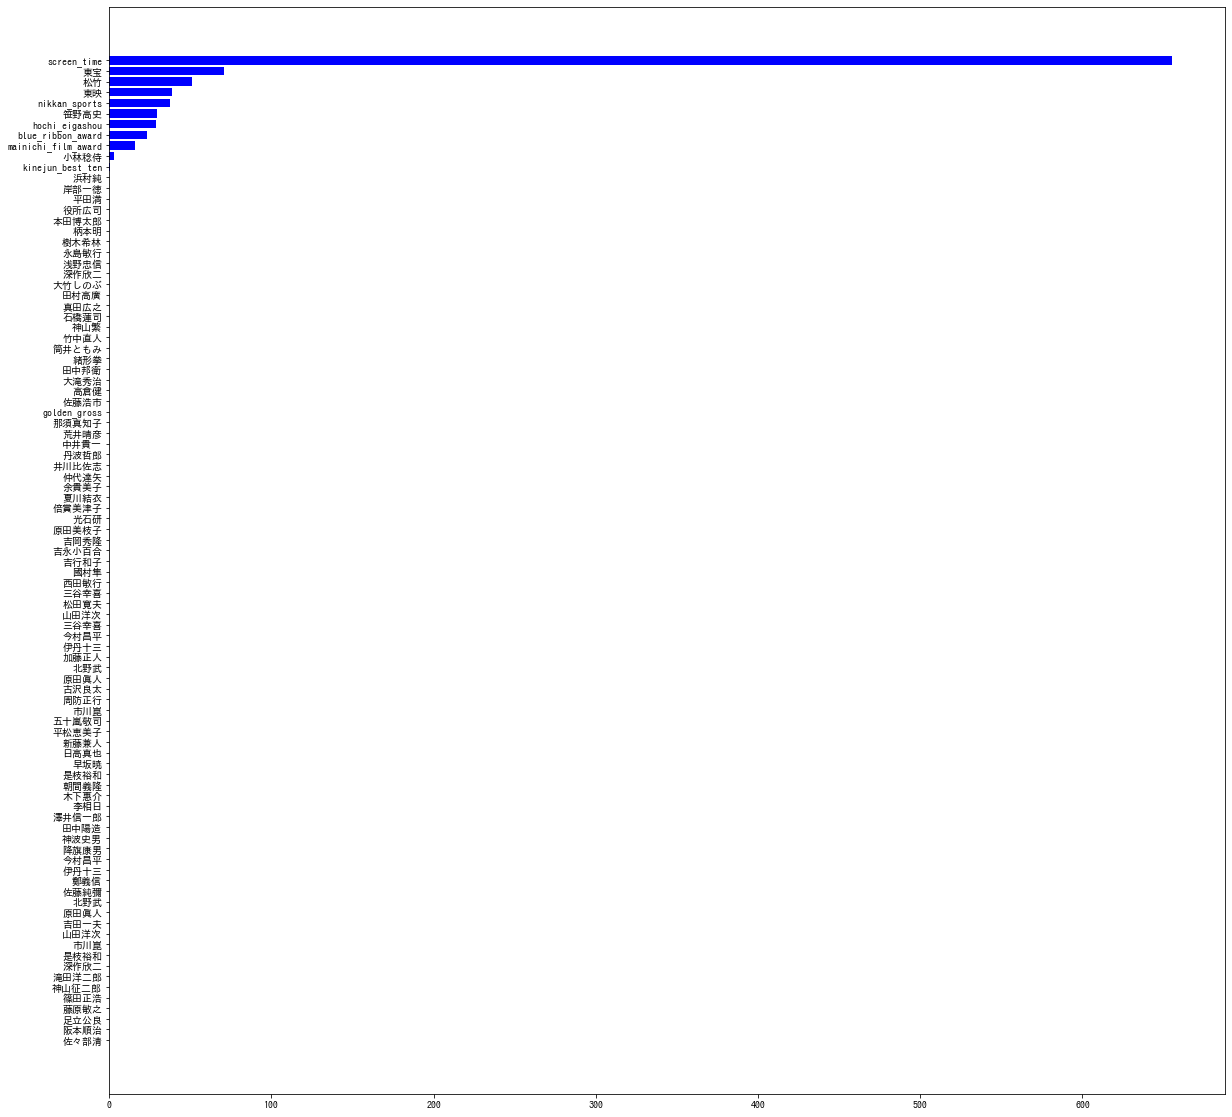

In [91]:
cv_gen = cv_generator(data, df)
predicted_ys = []
test_ys = []

for year in range(1978, 2020):
    train_x, train_y, test_x, test_y = next(cv_gen)
    
    print(train_x)
    model.fit(
        train_x,
        train_y,
        sample_weight=None,
        init_score=None,
        eval_set=None,
        eval_names=None,
        eval_sample_weight=None,
        eval_init_score=None,
        eval_metric=None, 
        early_stopping_rounds=None,
        verbose=True,
        feature_name='auto',
        categorical_feature='auto',
        callbacks=None
    )
    try:
        total_feature_importances += model.feature_importances_
    except NameError:
        total_feature_importances = model.feature_importances_

    # Print the feature ranking
    predicted_y = model.predict(
        test_x,
        raw_score=False,
        num_iteration=None,
        pred_leaf=False,
        pred_contrib=False,
    )
    test_ys.extend(test_y)
    predicted_ys.extend(predicted_y)

plot_feature_importance(feature_importances)
tn, fp, fn, tp = confusion_matrix(test_ys, predicted_ys).ravel()

In [90]:
model = lightgbm.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None,
    n_jobs=-1,
    silent=True,
    importance_type='split',
)

In [92]:
print("tn: {}, fp; {}, fn: {}, tp: {}".format(tn, fp, fn, tp))
total_positive = fp + tp
total_negative = fn + tn
print("total\n   positive: {}\n   nevative: {}".format(total_positive, total_negative))

tn: 162, fp; 7, fn: 29, tp: 13
total
   positive: 20
   nevative: 191


auc: 0.6340518455903071


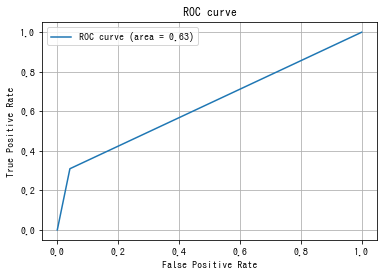

In [84]:
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test_ys, predicted_ys)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

print("auc: {}".format(auc))

## GridSearch